<a href="https://www.kaggle.com/code/oscarm524/ps-s4-ep3-eda-modeling-submission?scriptVersionId=165316689" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Loading Libraries

In [1]:
import pandas as pd; pd.set_option('display.max_columns', 100)
import numpy as np

import warnings
warnings.filterwarnings('ignore')

from tqdm.notebook import tqdm

import re

from functools import partial
from scipy.stats import mode

import matplotlib.pyplot as plt; plt.style.use('ggplot')
import seaborn as sns
import plotly.express as px

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder, FunctionTransformer, PowerTransformer, PolynomialFeatures
from sklearn.pipeline import make_pipeline, Pipeline, FeatureUnion
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.impute import KNNImputer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV, RepeatedStratifiedKFold, cross_val_score, cross_val_predict
from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay, cohen_kappa_score, log_loss, f1_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import RFE, RFECV
from sklearn.isotonic import IsotonicRegression
from sklearn.calibration import CalibrationDisplay, CalibratedClassifierCV
from sklearn.inspection import PartialDependenceDisplay, permutation_importance
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from collections import Counter
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, HistGradientBoostingClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier, StackingClassifier
from sklearn.svm import SVC, LinearSVC
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

from sklearn.neural_network import MLPClassifier

import optuna

# Reading Data Files

In [2]:
train = pd.read_csv('../input/playground-series-s4e3/train.csv')
test = pd.read_csv('../input/playground-series-s4e3/test.csv')
submission = pd.read_csv('../input/playground-series-s4e3/sample_submission.csv')

print('The dimension of the train dataset is:', train.shape)
print('The dimension of the test dataset is:', test.shape)

The dimension of the train dataset is: (19219, 35)
The dimension of the test dataset is: (12814, 28)


In [3]:
train.head()

id  X_Minimum  X_Maximum  Y_Minimum  Y_Maximum  Pixels_Areas  X_Perimeter  \
0   0        584        590     909972     909977            16            8   
1   1        808        816     728350     728372           433           20   
2   2         39        192    2212076    2212144         11388          705   
3   3        781        789    3353146    3353173           210           16   
4   4       1540       1560     618457     618502           521           72   

   Y_Perimeter  Sum_of_Luminosity  Minimum_of_Luminosity  \
0            5               2274                    113   
1           54              44478                     70   
2          420            1311391                     29   
3           29               3202                    114   
4           67              48231                     82   

   Maximum_of_Luminosity  Length_of_Conveyer  TypeOfSteel_A300  \
0                    140                1358                 0   
1                    111                1687                 1   
2                    141                1400                 0   
3                    134                1387                 0   
4                    111                1692                 0   

   TypeOfSteel_A400  Steel_Plate_Thickness  Edges_Index  Empty_Index  \
0                 1                     50       0.7393       0.4000   
1                 0                     80       0.7772       0.2878   
2                 1                     40       0.0557       0.5282   
3                 1                     40       0.7202       0.3333   
4                 1                    300       0.1211       0.5347   

   Square_Index  Outside_X_Index  Edges_X_Index  Edges_Y_Index  \
0        0.5000           0.0059         1.0000         1.0000   
1        0.2581           0.0044         0.2500         1.0000   
2        0.9895           0.1077         0.2363         0.3857   
3        0.3333           0.0044         0.3750         0.9310   
4        0.0842           0.0192         0.2105         0.9861   

   Outside_Global_Index  LogOfAreas  Log_X_Index  Log_Y_Index  \
0                   0.0      1.2041       0.9031       0.6990   
1                   1.0      2.6365       0.7782       1.7324   
2                   0.0      4.0564       2.1790       2.2095   
3                   1.0      2.3222       0.7782       1.4314   
4                   1.0      2.7694       1.4150       1.8808   

   Orientation_Index  Luminosity_Index  SigmoidOfAreas  Pastry  Z_Scratch  \
0            -0.5000           -0.0104          0.1417       0          0   
1             0.7419           -0.2997          0.9491       0          0   
2            -0.0105           -0.0944          1.0000       0          0   
3             0.6667           -0.0402          0.4025       0          0   
4             0.9158           -0.2455          0.9998       0          0   

   K_Scatch  Stains  Dirtiness  Bumps  Other_Faults  
0         0       1          0      0             0  
1         0       0          0      0             1  
2         1       0          0      0             0  
3         1       0          0      0             0  
4         0       0          0      0             1

In [4]:
test.head()

id  X_Minimum  X_Maximum  Y_Minimum  Y_Maximum  Pixels_Areas  \
0  19219       1015       1033    3826564    3826588           659   
1  19220       1257       1271     419960     419973           370   
2  19221       1358       1372     117715     117724           289   
3  19222        158        168     232415     232440            80   
4  19223        559        592     544375     544389           140   

   X_Perimeter  Y_Perimeter  Sum_of_Luminosity  Minimum_of_Luminosity  \
0           23           46              62357                     67   
1           26           28              39293                     92   
2           36           32              29386                    101   
3           10           11               8586                    107   
4           19           15              15524                    103   

   Maximum_of_Luminosity  Length_of_Conveyer  TypeOfSteel_A300  \
0                    127                1656                 0   
1                    132                1354                 0   
2                    134                1360                 0   
3                    140                1690                 1   
4                    134                1688                 1   

   TypeOfSteel_A400  Steel_Plate_Thickness  Edges_Index  Empty_Index  \
0                 1                    150       0.3877       0.4896   
1                 1                     40       0.1629       0.4136   
2                 1                     40       0.0609       0.6234   
3                 0                    100       0.4439       0.3333   
4                 0                     60       0.8191       0.2619   

   Square_Index  Outside_X_Index  Edges_X_Index  Edges_Y_Index  \
0        0.3273           0.0095         0.5652         1.0000   
1        0.0938           0.0047         0.2414         1.0000   
2        0.4762           0.0155         0.6000         0.7500   
3        0.8182           0.0037         0.8000         1.0000   
4        0.4286           0.0158         0.8421         0.5333   

   Outside_Global_Index  LogOfAreas  Log_X_Index  Log_Y_Index  \
0                   1.0      2.8410       1.1139       1.6628   
1                   1.0      2.5682       0.9031       1.4472   
2                   0.0      2.4609       1.3222       1.3222   
3                   1.0      1.9031       0.6990       1.0414   
4                   0.0      2.1461       1.3222       1.1461   

   Orientation_Index  Luminosity_Index  SigmoidOfAreas  
0             0.6727           -0.2261          0.9172  
1             0.9063           -0.1453          0.9104  
2            -0.5238           -0.0435          0.6514  
3             0.1818           -0.0738          0.2051  
4            -0.5714           -0.0894          0.4170

First, let's check for missing values in the `train` and `test` data frames.

In [5]:
train.isnull().sum()

id                       0
X_Minimum                0
X_Maximum                0
Y_Minimum                0
Y_Maximum                0
Pixels_Areas             0
X_Perimeter              0
Y_Perimeter              0
Sum_of_Luminosity        0
Minimum_of_Luminosity    0
Maximum_of_Luminosity    0
Length_of_Conveyer       0
TypeOfSteel_A300         0
TypeOfSteel_A400         0
Steel_Plate_Thickness    0
Edges_Index              0
Empty_Index              0
Square_Index             0
Outside_X_Index          0
Edges_X_Index            0
Edges_Y_Index            0
Outside_Global_Index     0
LogOfAreas               0
Log_X_Index              0
Log_Y_Index              0
Orientation_Index        0
Luminosity_Index         0
SigmoidOfAreas           0
Pastry                   0
Z_Scratch                0
K_Scatch                 0
Stains                   0
Dirtiness                0
Bumps                    0
Other_Faults             0
dtype: int64

In [6]:
test.isnull().sum()

id                       0
X_Minimum                0
X_Maximum                0
Y_Minimum                0
Y_Maximum                0
Pixels_Areas             0
X_Perimeter              0
Y_Perimeter              0
Sum_of_Luminosity        0
Minimum_of_Luminosity    0
Maximum_of_Luminosity    0
Length_of_Conveyer       0
TypeOfSteel_A300         0
TypeOfSteel_A400         0
Steel_Plate_Thickness    0
Edges_Index              0
Empty_Index              0
Square_Index             0
Outside_X_Index          0
Edges_X_Index            0
Edges_Y_Index            0
Outside_Global_Index     0
LogOfAreas               0
Log_X_Index              0
Log_Y_Index              0
Orientation_Index        0
Luminosity_Index         0
SigmoidOfAreas           0
dtype: int64

There are no missing values neither in the `train` or `test` data frames. Next, we check for duplicates.

In [7]:
print(f"There are {sum(train.drop(columns='id').duplicated())} duplicated rows in the train data frame.")

print("\n")
print(f"After dropping the target columns, there are {sum(train.drop(columns=['id', 'Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults']).duplicated())} duplicated rows in the train data frame.")

print("\n")
print(f"There are {sum(test.drop(columns='id').duplicated())} duplicated rows in the test data frame.")

There are 0 duplicated rows in the train data frame.


After dropping the target columns, there are 0 duplicated rows in the train data frame.


There are 0 duplicated rows in the test data frame.


Finally, we check if there are any observations that appear in both the `train` and `test` data frames.

In [8]:
temp_train = train.drop(columns=['id', 'Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults'], axis=1)
temp_test = test.drop(columns='id', axis=1)

inner_join = pd.merge(temp_train, temp_test)
print(f"There are {inner_join.shape[0]} observations that appear in both the train and test data frames")

There are 0 observations that appear in both the train and test data frames


# Data Exploration

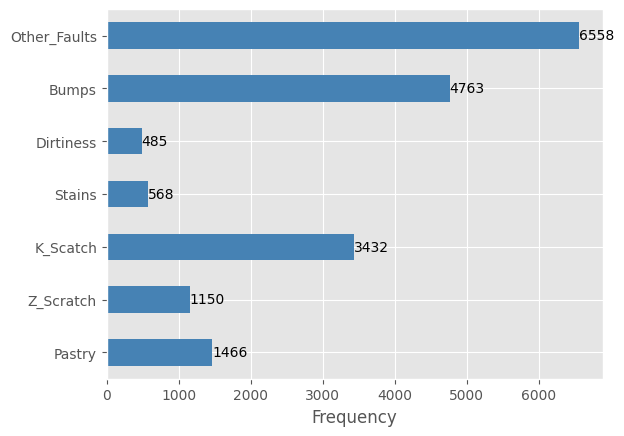

In [9]:
ax = train[['Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults']].sum(axis=0).plot(kind='barh', color='steelblue')
ax.bar_label(ax.containers[0], label_type = 'edge')
plt.xlabel('Frequency');

From the above chart, it is clear that the data is imbalanced. We next proceed to explore potential relationship between the input features and the target features. First, we create a feature called `target` as follows:

In [10]:
train['target'] = np.where(train['Pastry']==1, 'Pastry',
                           np.where(train['Z_Scratch']==1, 'Z_Scratch',
                                    np.where(train['K_Scatch']==1, 'K_Scatch',
                                             np.where(train['Stains']==1, 'Stains',
                                                      np.where(train['Dirtiness']==1, 'Dirtiness',
                                                               np.where(train['Bumps']==1, 'Bumps', 'Other_Faults'))))))

Next, we create some scatter-plots to explore bivariate realtionships taking into account `target` value.

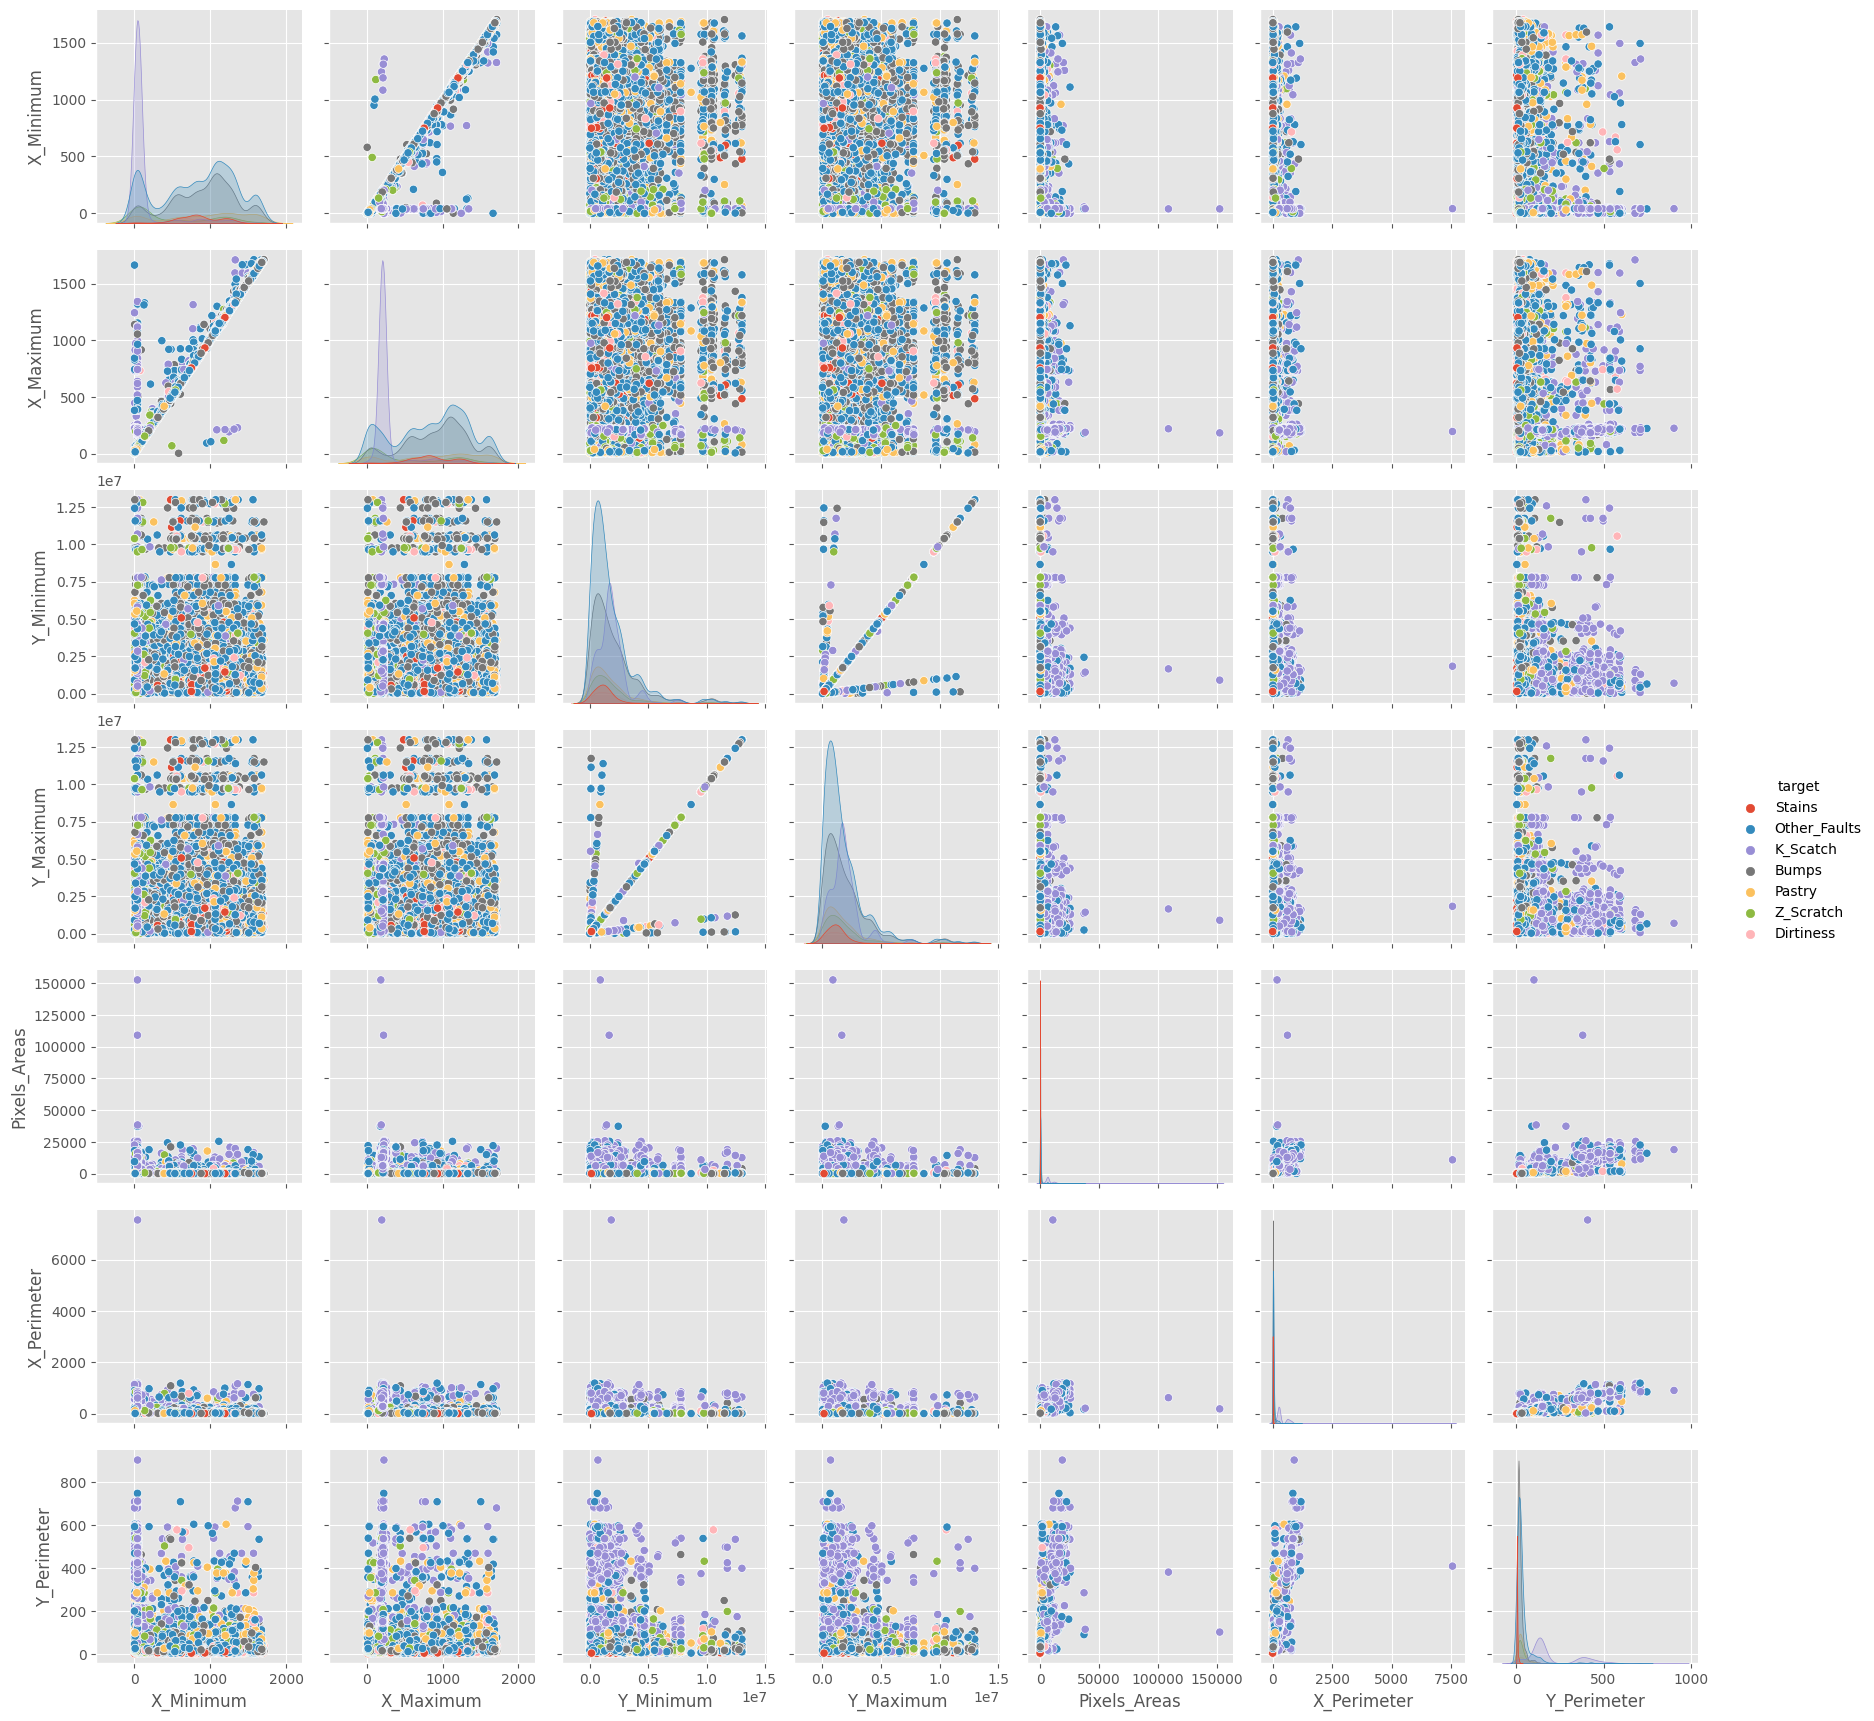

In [11]:
sns.pairplot(train[['X_Minimum', 'X_Maximum', 'Y_Minimum', 'Y_Maximum', 'Pixels_Areas', 'X_Perimeter', 'Y_Perimeter', 'target']], hue='target');

From the above plots, these are some observations:

- `X_Minimum` and `X_Maximum` seem to be linearly related for the most part.
- `X_Perimeter` and `Y_Perimeter` seem to be linearly related.
- `Y_Perimeter` and `Pixels_Areas` seem to be linearly related for the most part.
- There are some outliers.

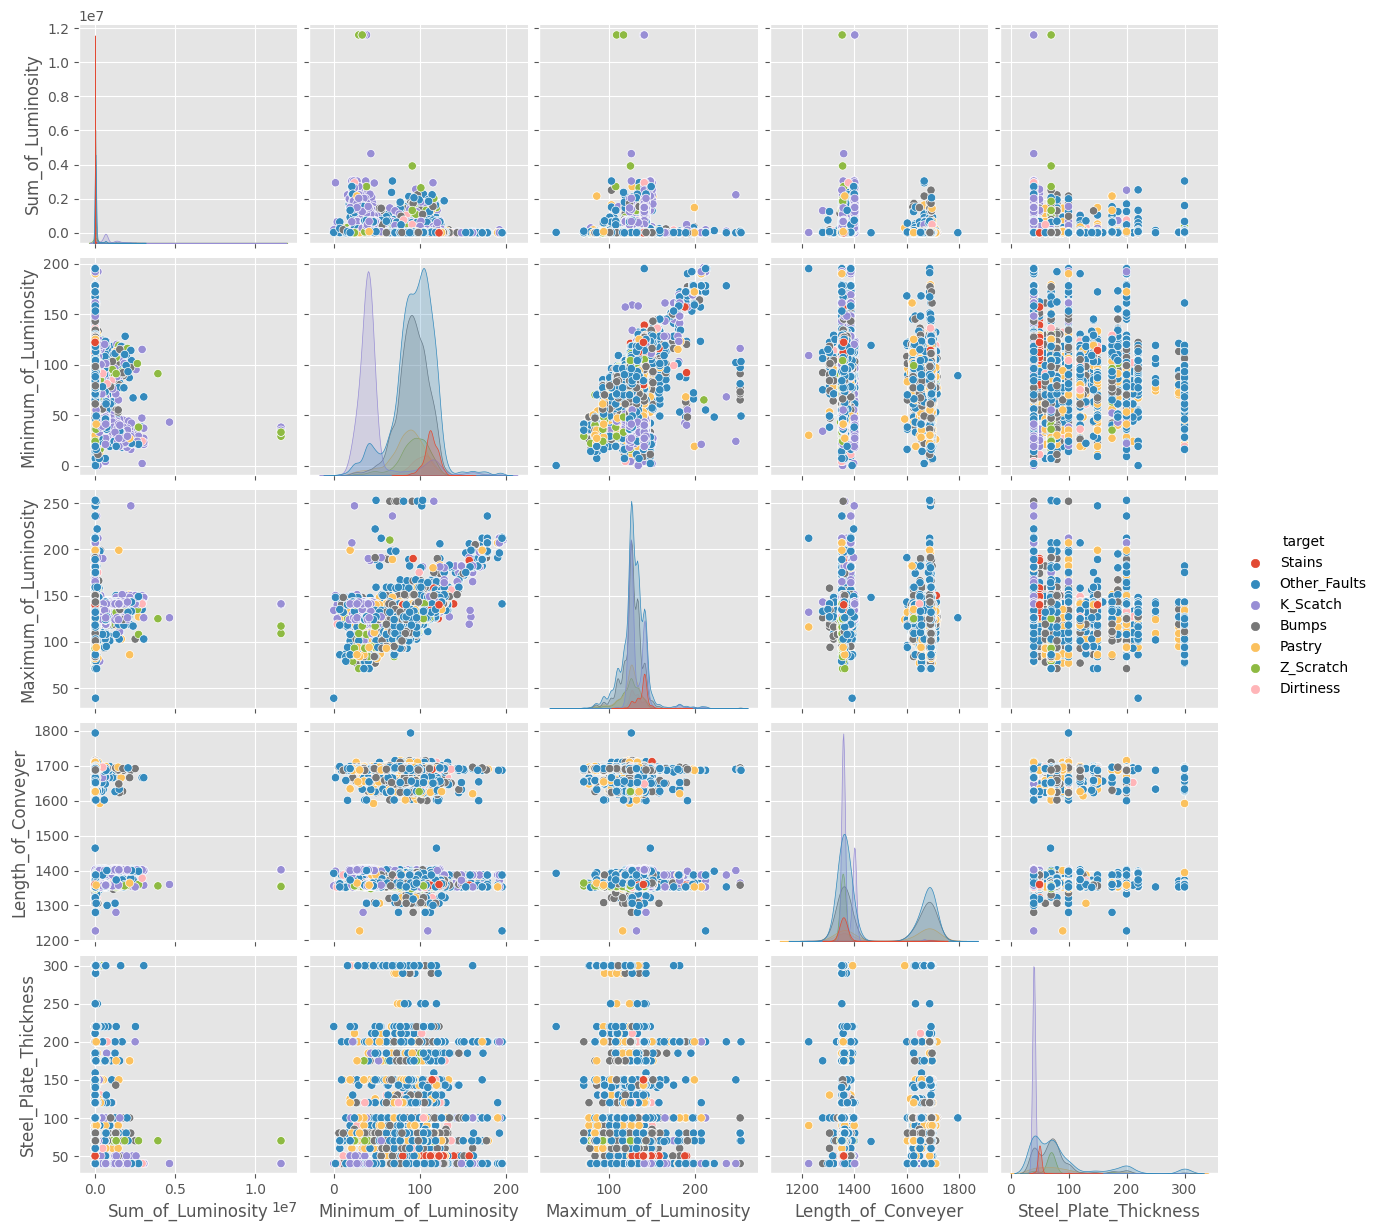

In [12]:
sns.pairplot(train[['Sum_of_Luminosity', 'Minimum_of_Luminosity', 'Maximum_of_Luminosity', 'Length_of_Conveyer', 'Steel_Plate_Thickness', 'target']], hue='target');

From the above plots, these are some observations:

- `Minimum_of_Luminosity` and `Maximum_of_Luminosity` seem to be linearly related for the most part with outliers.
- There are outliers.

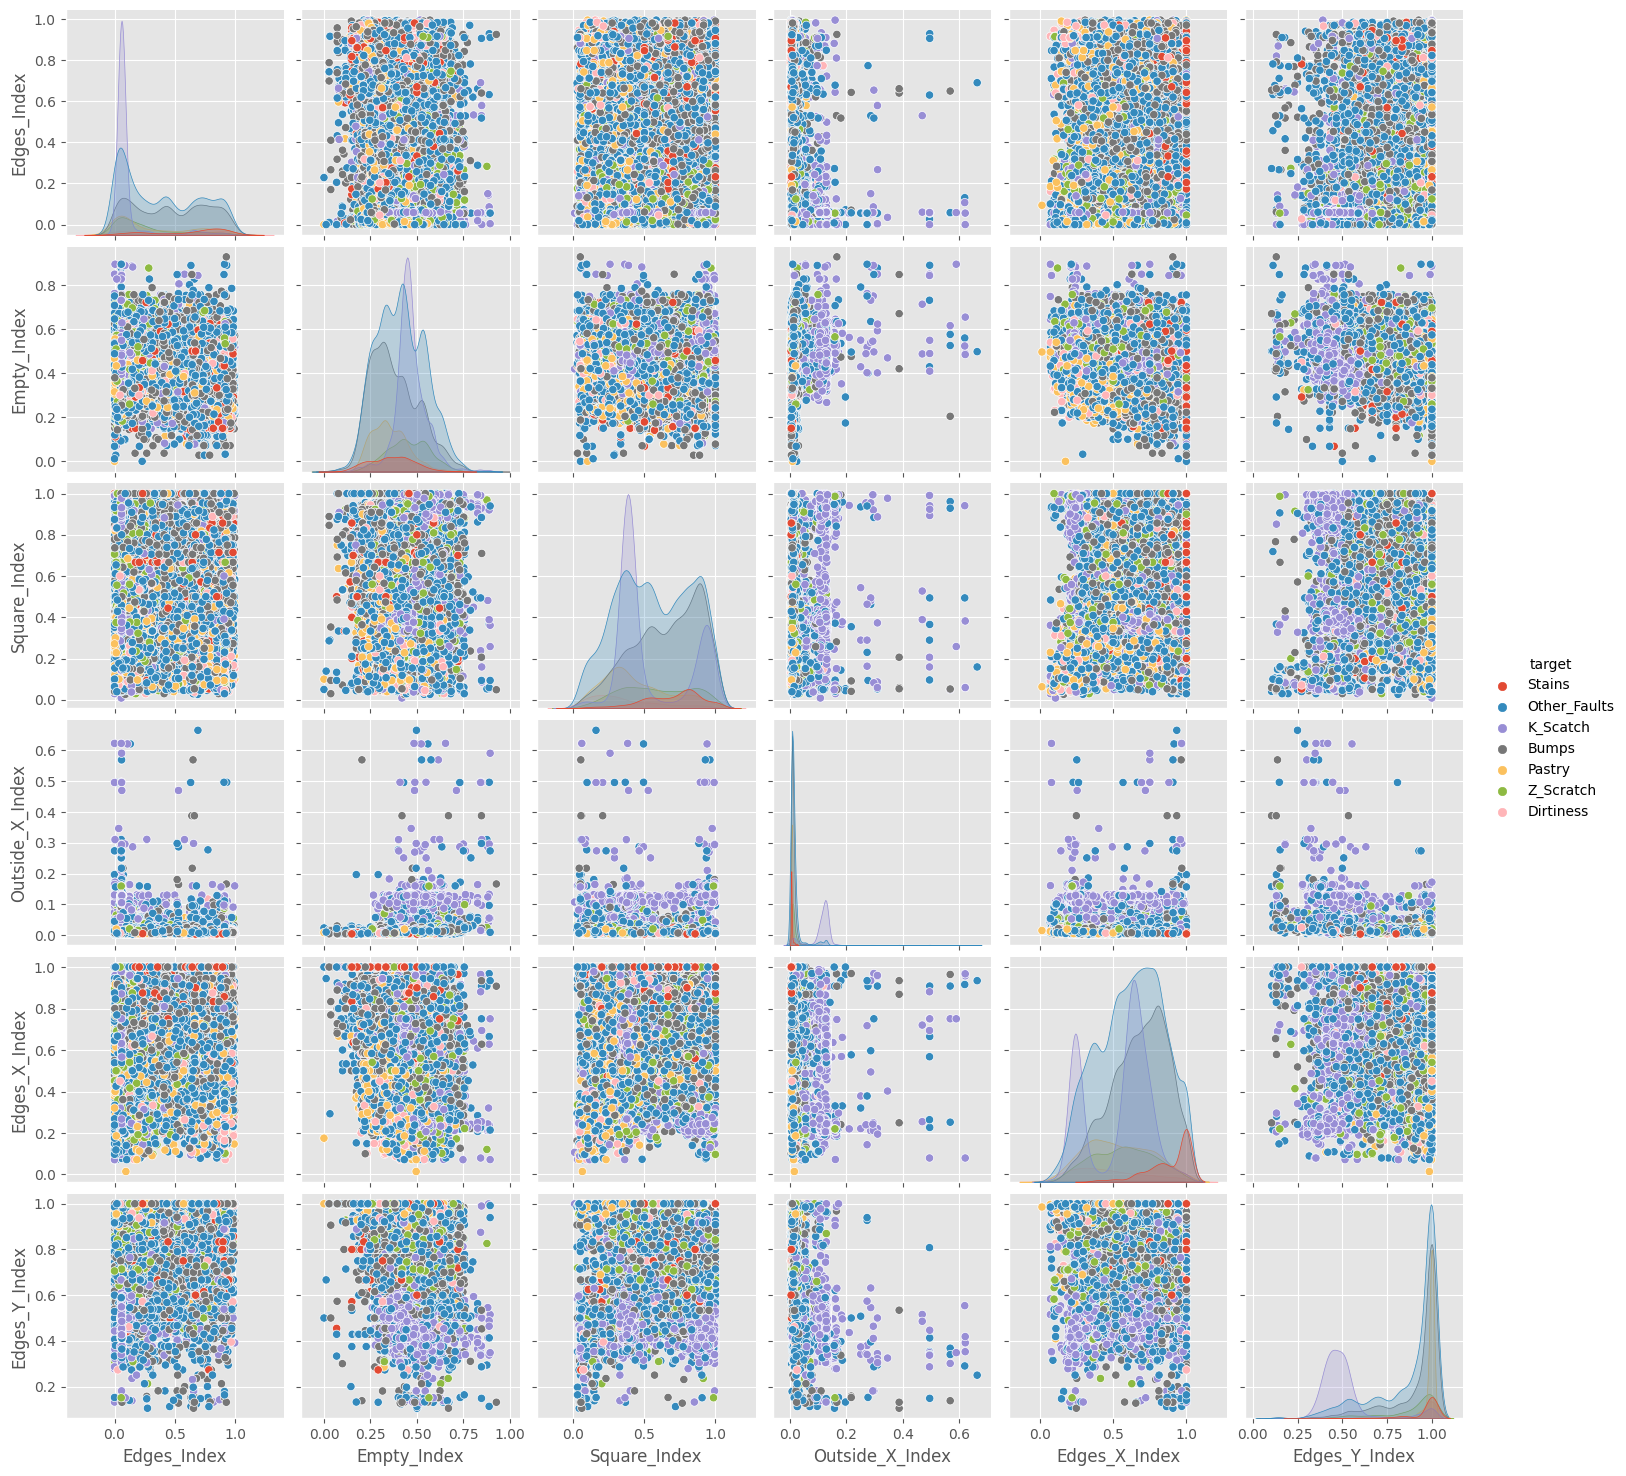

In [13]:
sns.pairplot(train[['Edges_Index', 'Empty_Index', 'Square_Index', 'Outside_X_Index', 'Edges_X_Index', 'Edges_Y_Index', 'target']], hue='target');

From the above plots, these is an observation:

- For the most part, `Stains` occurs when `Edges_X_Index`.

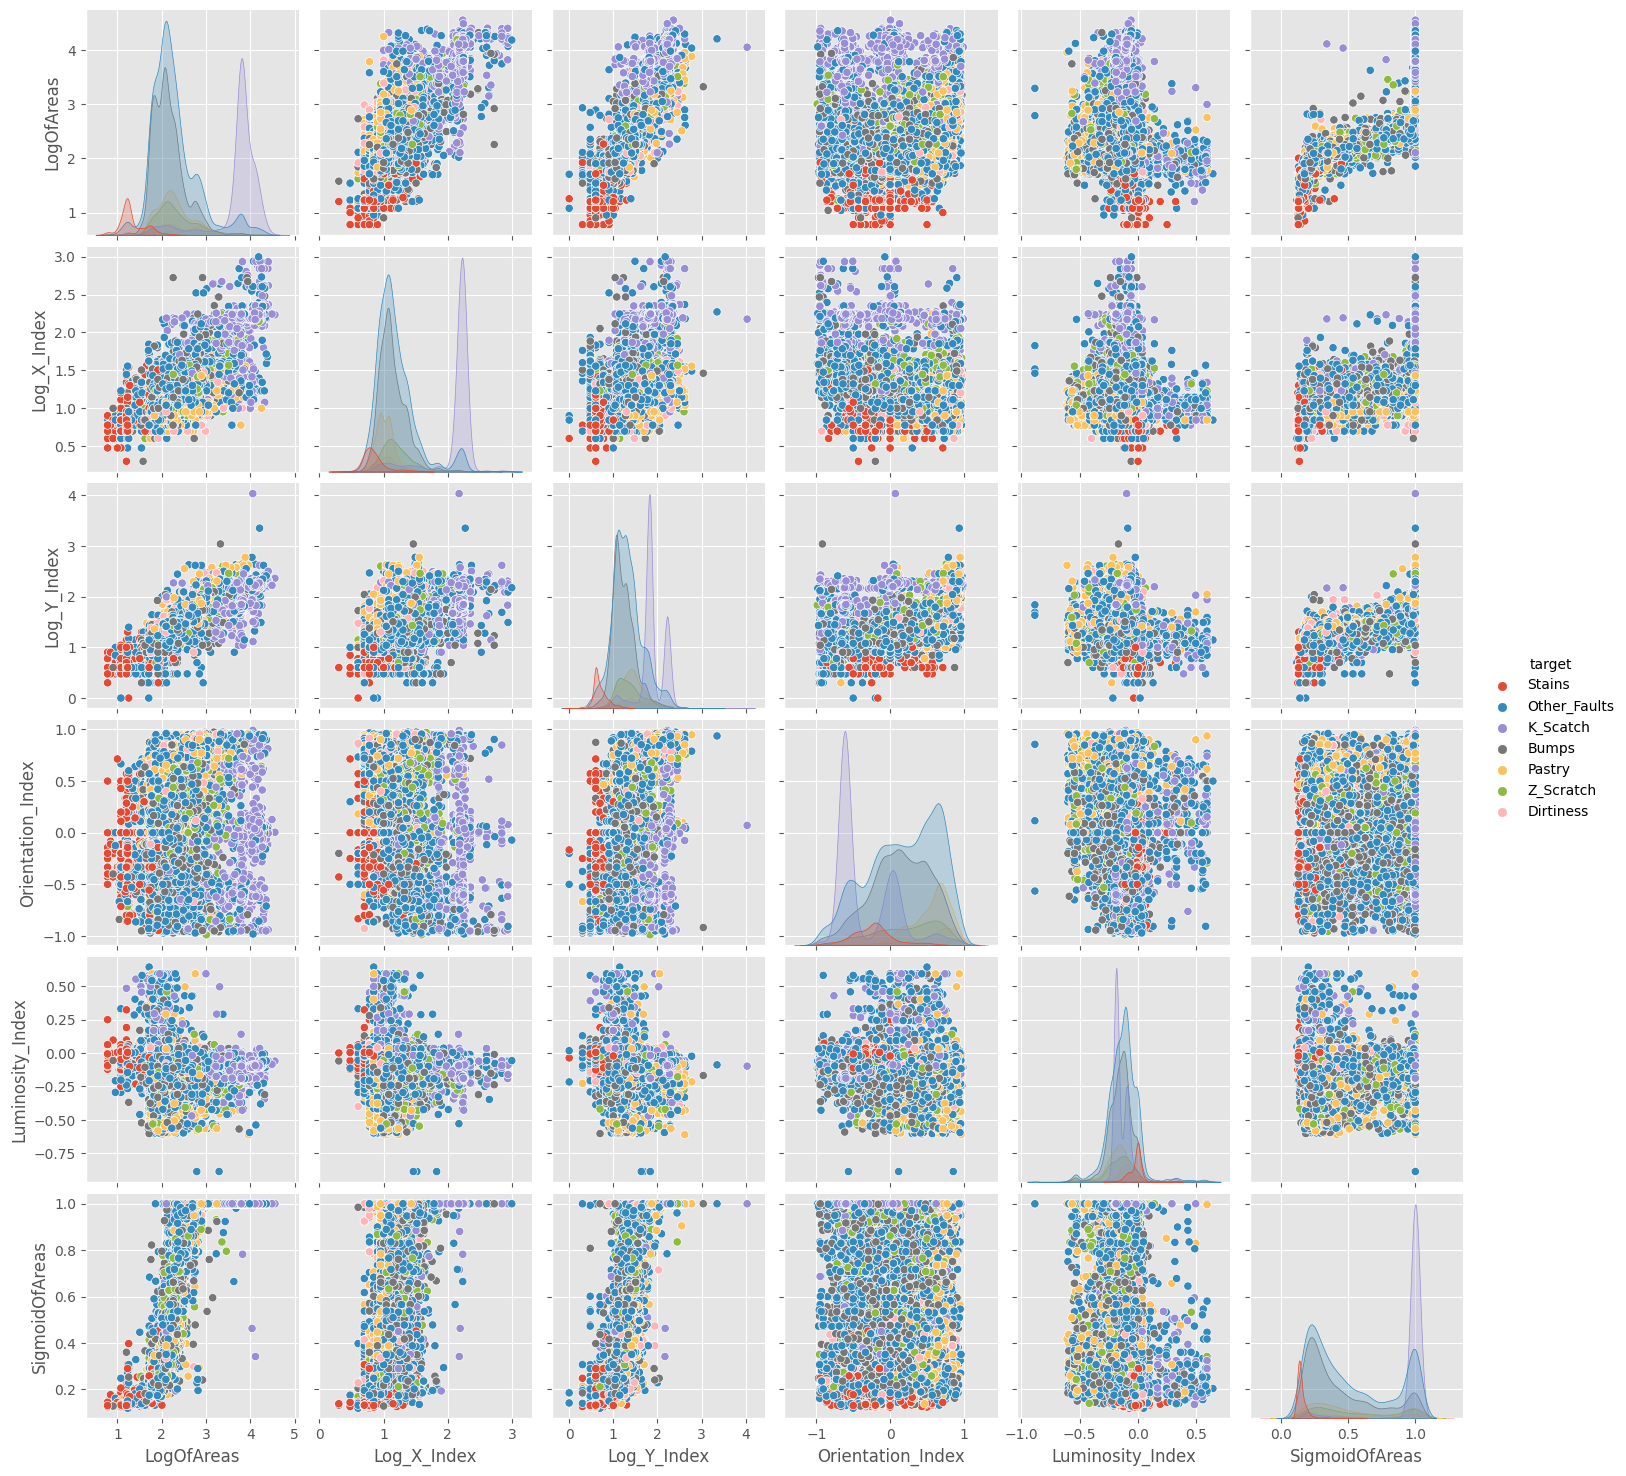

In [14]:
sns.pairplot(train[['LogOfAreas', 'Log_X_Index', 'Log_Y_Index', 'Orientation_Index', 'Luminosity_Index', 'SigmoidOfAreas', 'target']], hue='target');

From the above plots, these is an observation:

- `LogOfAreas` seem to be linearly related with `Log_X_Index` and `Log_Y_Index`. 

In [15]:
pd.crosstab(train['target'], train['TypeOfSteel_A300'])

TypeOfSteel_A300     0     1
target                      
Bumps             1842  2919
Dirtiness          408    77
K_Scatch          3403    28
Other_Faults      4137  3221
Pastry             894   572
Stains             534    34
Z_Scratch          262   888

In [16]:
pd.crosstab(train['target'], train['TypeOfSteel_A400'])

TypeOfSteel_A400     0     1
target                      
Bumps             2919  1842
Dirtiness           77   408
K_Scatch            43  3388
Other_Faults      3223  4135
Pastry             573   893
Stains              35   533
Z_Scratch          888   262

In [17]:
train['Outside_Global_Index'].value_counts()

Outside_Global_Index
1.0    11022
0.0     7490
0.5      706
0.7        1
Name: count, dtype: int64

The value 0.7 seem to be an outlier. We replace 0.7 with 0.5

In [18]:
train['Outside_Global_Index'] = np.where(train['Outside_Global_Index']==0.7, 0.5, train['Outside_Global_Index'])

# Baseline Modeling 1.0

In this section, we train a few standard models with raw data.

In [19]:
X = train[['LogOfAreas', 'Log_X_Index', 'Log_Y_Index', 'Orientation_Index']] 
Y = train['target']

le = LabelEncoder()
Y = le.fit_transform(Y)

skf = RepeatedStratifiedKFold(n_splits=10, n_repeats=1, random_state=42)

In [20]:
%%time
RF_cv = cross_val_score(RandomForestClassifier(n_estimators=500,
                                               max_depth=10,
                                               min_samples_split=20,
                                               min_samples_leaf=30,
                                               random_state=10),
                        X, 
                        Y, 
                        scoring = 'roc_auc_ovr',
                        cv = skf, 
                        n_jobs = -1)

print(f"The average 10-folds oof accuracy score of the Random Forest model is {RF_cv.mean()}")

The average 10-folds oof accuracy score of the Random Forest model is 0.8063003242571212
CPU times: user 212 ms, sys: 130 ms, total: 342 ms
Wall time: 35.2 s


In [21]:
test_cv = test[['LogOfAreas', 'Log_X_Index', 'Log_Y_Index', 'Orientation_Index']].copy()

RF_md = RandomForestClassifier(n_estimators=500,
                               max_depth=10,
                               min_samples_split=20,
                               min_samples_leaf=30,
                               random_state=10).fit(X, Y)

preds = RF_md.predict_proba(test_cv)

In [22]:
le.classes_

array(['Bumps', 'Dirtiness', 'K_Scatch', 'Other_Faults', 'Pastry',
       'Stains', 'Z_Scratch'], dtype=object)

In [23]:
submission['Pastry'] = preds[:, 4]
submission['Z_Scratch'] = preds[:,6 ]
submission['K_Scatch'] = preds[:, 2]
submission['Stains'] = preds[:, 5]
submission['Dirtiness'] = preds[:, 1]
submission['Bumps'] = preds[:, 0]
submission['Other_Faults'] = preds[:, 3]

submission.head()

id    Pastry  Z_Scratch  K_Scatch    Stains  Dirtiness     Bumps  \
0  19219  0.259737   0.069544  0.011272  0.000025   0.074518  0.153172   
1  19220  0.280710   0.040456  0.005336  0.000016   0.106311  0.135307   
2  19221  0.006579   0.087723  0.033218  0.006312   0.005947  0.377742   
3  19222  0.139619   0.047358  0.027956  0.014455   0.015772  0.357777   
4  19223  0.006558   0.091170  0.033818  0.009865   0.006328  0.363984   

   Other_Faults  
0      0.431731  
1      0.431865  
2      0.482478  
3      0.397063  
4      0.488278

In [24]:
submission.to_csv('baseline_sub_1.csv', index=False)